/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - Loss: 0.9705623984336853
Epoch 2/3 - Loss: 0.4796381890773773
Epoch 3/3 - Loss: 1.4804497957229614


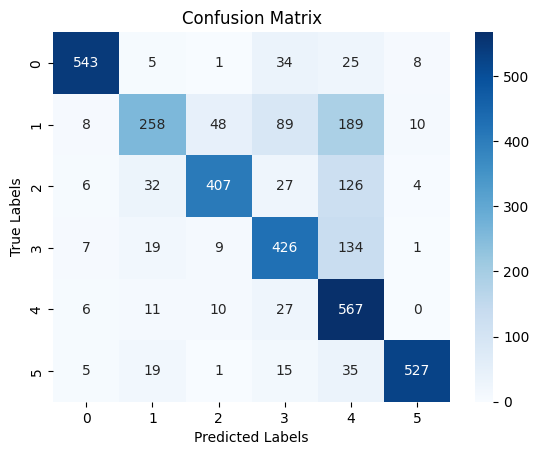

              precision    recall  f1-score   support

       korku       0.94      0.88      0.91       616
   küçümseme       0.75      0.43      0.55       602
    mutluluk       0.86      0.68      0.76       602
        öfke       0.69      0.71      0.70       596
      üzüntü       0.53      0.91      0.67       621
   şaşkınlık       0.96      0.88      0.91       602

    accuracy                           0.75      3639
   macro avg       0.79      0.75      0.75      3639
weighted avg       0.79      0.75      0.75      3639



In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import ElectraTokenizer, ElectraForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import AdamW

# 1. Verilerin Yüklenmesi ve Hazırlanması
df = pd.read_excel('/content/sample_data/duygular_stemmed.xlsx')  # Excel dosyanızın adını girin

# Eksik veya boş değerleri kontrol etme ve temizleme
df.dropna(subset=['comments'], inplace=True)

comments = df['comments'].astype(str).tolist()  # Metinleri string olarak alma
labels = df['label']

# Etiketleri sayısal hale getirme
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

# Model ve Tokenizer'ı yükleme
model_name = 'google/electra-base-discriminator'
tokenizer = ElectraTokenizer.from_pretrained(model_name)
model = ElectraForSequenceClassification.from_pretrained(model_name, num_labels=6)

# Tokenizasyon ve padding
def preprocess_data(texts, tokenizer, max_length=128):
    inputs = tokenizer(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return inputs['input_ids'], inputs['attention_mask']

input_ids, attention_masks = preprocess_data(comments, tokenizer)

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(input_ids, encoded_labels, test_size=0.2, random_state=42)
train_masks, test_masks, _, _ = train_test_split(attention_masks, attention_masks, test_size=0.2, random_state=42)

# Etiketleri tensora dönüştürme
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Veriyi DataLoader'a dönüştürme
batch_size = 16

train_data = TensorDataset(X_train, train_masks, y_train)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(X_test, test_masks, y_test)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Eğitim parametreleri
optimizer = AdamW(model.parameters(), lr=2e-5)

# Eğitim döngüsü
epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item()}")

# Modeli değerlendirme
model.eval()
predictions, true_labels = [], []
for batch in test_dataloader:
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
    logits = outputs.logits
    predicted_labels = torch.argmax(logits, dim=-1)
    predictions.append(predicted_labels.cpu().numpy())
    true_labels.append(b_labels.cpu().numpy())

# Performans değerlendirme
predictions = [item for sublist in predictions for item in sublist]
true_labels = [item for sublist in true_labels for item in sublist]

# Confusion matrix oluşturma
conf_matrix = confusion_matrix(true_labels, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Sınıflandırma raporu oluşturma
report = classification_report(true_labels, predictions, target_names=encoder.classes_)
print(report)
